# Building ML Model


In [1]:
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

In [2]:
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def Clean_Text(text):
    """ Removes Stopwords from an input string
    Parameters
    ----------
    text : string
      Input Tweet
    Returns
    text : string
      Preprocessed Tweet
    -------
    """
    text = str(text)
    text = re.sub(r'"','', text)
    text = re.sub(r'&amp','', text)
    text = re.sub(r'@[A-Za-z0-9_]+','@USER', text)#Remove's @'s
    text = re.sub(r'RT[\s]+','', text) # removes rt's
    text = re.sub(r'http?:\/\/\S+', 'HTTPURL', text)# removes hyperlinks
    text = re.sub(r'https?:\/\/\S+', 'HTTPURL', text)# removes hyperlinks
    text = re.sub(r'[&8216;]+','',text)#removes apostrophes that are miscoded
    text = re.sub(r'[&8217;]+','',text)#removes apostrophes that are miscoded
    text = re.sub(r'[\n]+','',text)#removes \n's
    text = re.sub(r'[0-9]+','',text)#removes all integers
    text = re.sub(r'[!]+','',text)
    text = re.sub(r':','',text)
    text = re.sub(r',',' ',text)
    text = re.sub(r'[.]+',' ',text)
    text = re.sub(r' +', ' ', text)
    text = " ".join(word.strip() for word in re.split('#|_', text))
    text = text.lower()
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text)
    return text


def ChangeToBin_Davidson(integer):
    """ Changes davidson dataset to binary encoding as opposed to tri-class, making offensive class part of the non-hate class
    Parameters
    ----------
    integer : int
      True labels for each of the samples in the training data
    Returns
    integer : int
      True labels in binary form
    -------
    """
    if integer == 0:
      integer = 1
    else:
      integer = 0
    return integer



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
# Initial Configuration Variable
datasetType = 1 

In [6]:
import tensorflow as tf
import nltk


from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
stop = set(stopwords.words("english"))

def remove_stopwords(text):
  text = [word.lower() for word in text.split() if word.lower() not in stop]

  return " ".join(text)


df_train = pd.read_csv("train_tweet.csv")
df_test = pd.read_csv("labeled_data.csv")



df_train['text'] = df_train['tweet'].apply(Clean_Text)
df_train['text'] = df_train["text"].map(remove_stopwords)


df_train = df_train.drop(["id", "tweet"], axis = 1)



df_test['text'] = df_test['tweet'].apply(Clean_Text)
df_test['text'] = df_test["text"].map(remove_stopwords)
df_test["label"] = df_test["class"].apply(ChangeToBin_Davidson)



df_test = df_test.drop(['index', 'count', 'hate_speech', 'offensive_language', 'neither','class', 'tweet'], axis = 1)


frames = [df_train, df_test]
dataset = pd.concat(frames)





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [7]:
df_train.head()

,label,text
0,0,@user father dysfunctional selfish drags kids ...
1,0,@user @user thanks lyft credit can't use cause...
2,0,bihday majesty
3,0,model love u take u time urð± ðððð...
4,0,factsguide society motivation


In [11]:
hate_speech_test =[] 
non_hate_speech_test = []
hate_speech_train = []
non_hate_speech_train = []
train_dataset = []


if datasetType == 1: # 90:10 split
  train_dataset = dataset.sample(frac = 0.9, random_state = 200)
  test_dataset = dataset.drop(train_dataset.index)
  hate_speech_test = test_dataset[test_dataset.label.eq(1)] # ensures balanced datasets
  non_hate_speech_test = test_dataset[test_dataset.label.eq(0)]

elif datasetType == 2:  # ensures balanced datasets
  hate_speech_test = df_test[df_test.label.eq(1)] 
  non_hate_speech_test = df_test[df_test.label.eq(0)]
  hate_speech_train = df_train[df_train.label.eq(1)]
  non_hate_speech_train = df_train[df_train.label.eq(0)]

  equal_non_hate_speech_train = non_hate_speech_train.sample(len(hate_speech_train))
  frames = [hate_speech_train,equal_non_hate_speech_train]

  train_dataset = pd.concat(frames)


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder() # encodes each tweet
with tf.device(device_name):
  

  new_encoded_dataset = le.fit_transform(train_dataset["text"])
  encoded_text_test_hate_speech = le.fit_transform(hate_speech_test["text"])
  encoded_text_test_non_hate_speech = le.fit_transform(non_hate_speech_test["text"])

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# creates model and ensures it fits the data
model = KNeighborsClassifier(n_neighbors= 499, weights = 'uniform')
model.fit(new_encoded_dataset.reshape(-1,1), train_dataset["label"])


KNeighborsClassifier(n_neighbors=499)

In [14]:
y_pred = model.predict(encoded_text_test_hate_speech.reshape(-1,1))

In [15]:
from sklearn.metrics import accuracy_score # computes accuracy versus hate speech
accuracy = accuracy_score(hate_speech_test["label"], y_pred)
print('Accuracy',accuracy)

Accuracy 0.0


In [16]:
y_pred = model.predict(encoded_text_test_non_hate_speech.reshape(-1,1))

In [17]:
from sklearn.metrics import accuracy_score # computes accuracy versus non hate speech set
accuracy = accuracy_score(non_hate_speech_test["label"], y_pred)
print('Accuracy',accuracy)

Accuracy 1.0


# Code for Testing Best K

In [ ]:
import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import math
iterations = []
hate_accuracies = []
non_hate_accuracies = []

#tests best K from 1 to 500 using previous steps
with tf.device(device_name):
  for i in range(1,500):
    model = KNeighborsClassifier(n_neighbors=i, weights = "distance")
    model.fit(new_encoded_dataset.reshape(-1,1), train_dataset["label"])
    y_pred = model.predict(encoded_text_test_hate_speech.reshape(-1,1))
    hate_accuracy = accuracy_score(hate_speech_test["label"], y_pred)
    iterations.append(i)
    hate_accuracies.append(hate_accuracy)
    y_pred = model.predict(encoded_text_test_non_hate_speech.reshape(-1,1))
    non_hate_accuracy = accuracy_score(non_hate_speech_test["label"], y_pred)
    non_hate_accuracies.append(non_hate_accuracy)






Average Hate Speech Accuracy 0.620979020979013
Average Non Hate Speech Accuracy 0.9133730141737707


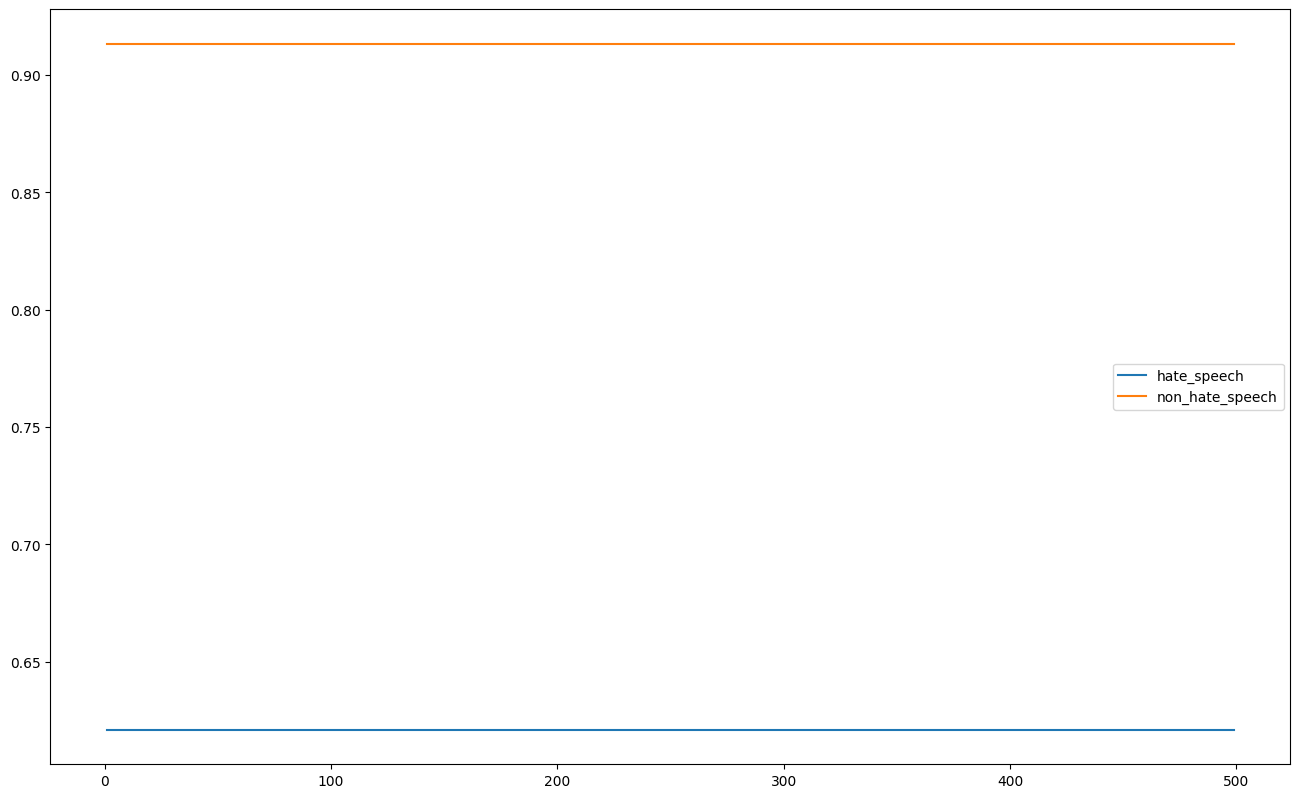

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# plots the hate speech and non-hate speech data

print("Average Hate Speech Accuracy", sum(hate_accuracies)/len(hate_accuracies))
print("Average Non Hate Speech Accuracy", sum(non_hate_accuracies)/len(non_hate_accuracies))

figure(figsize=(16, 10), dpi=100)
plt.plot(iterations, hate_accuracies, label = "hate_speech")
plt.plot(iterations, non_hate_accuracies, label = "non_hate_speech")
plt.legend()